### Imports

In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

### Understanding Derivatives

In [2]:
def f(x):
    return 3*x**2 - 4*x + 5 #sample function

In [3]:
f(3.0)

20.0

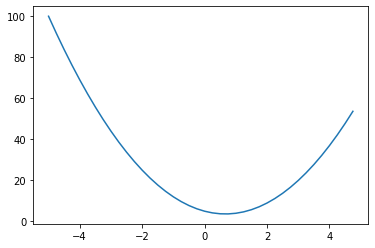

In [4]:
xs = np.arange(-5,5,0.25)
ys = f(xs)
plt.plot(xs,ys)

In [5]:
h = 0.0001
def derivative_info(x, delta):
    print(f"fn value at x: {f(x)}")
    print(f"fn value at x+h: {f(x+h)}")
    print(f"difference in value: {f(x+h) - f(x)}")
    print(f"slope (strength or rate of change of dependent variable as independent var changes: {(f(x+h)-f(x))/h}")

In [6]:
derivative_info(3, h)

fn value at x: 20
fn value at x+h: 20.001400030000006
difference in value: 0.0014000300000063248
slope (strength or rate of change of dependent variable as independent var changes: 14.000300000063248


In [7]:
derivative_info(-3, h)

fn value at x: 44
fn value at x+h: 43.99780002999999
difference in value: -0.0021999700000066014
slope (strength or rate of change of dependent variable as independent var changes: -21.999700000066014


### Value class for computational graph 

In [42]:
class Value:
    
    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self.grad = 0.0 #at initializtion, op is not affected by Value object
        self._backward = lambda: None # None for leaf nodes in the graph
        self._prev = set(_children)
        self._op = _op
        self.label = label
        
    def __repr__(self):
        return f"Value(data={self.data})"
    
    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        """
        ^ to work with non-value objects by wrapping them around Value and thereby providing them a data attribute
        eg: to perform a + 1 (where 1 is not a Value object)

        """
        out = Value(self.data + other.data, (self, other), '+')
        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad
        out._backward = _backward
        return out
    
    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other), '*')
        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward
        return out
    
    def __pow__(self, other):
        assert isinstance(other, (int, float)), "only supporting int/float powers for now"
        out = Value(self.data**other, (self,), f'**{other}')

        def _backward():
            self.grad += other * (self.data ** (other-1)) * out.grad
        out._backward = _backward
        
        return out

    def __rmul__(self, other): #other * self
        #fallback for regular __mul__ for cases involving non-Value object * Value object
        return self * other
        
    def __truediv__(self, other): #self/other
        return self * other**-1
    
    def __neg__(self): #(-self)
        return self * -1
    
    def __sub__(self, other): #(self-other)
        return self + (-other)
    
    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
        out = Value(t, (self, ), 'tanh')
        
        def _backward():
            self.grad += (1 - t**2) * out.grad
        out._backward = _backward
        return out
    
    def exp(self):
        x = self.data
        out = Value(math.exp(x), (self, ), 'exp')
        
        def _backward():
            self.grad += out.data * out.grad
        out._backward = _backward
        
        return out
    
    
    
    def backward(self):
        
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)

        self.grad = 1.0
        for node in reversed(topo):
            node._backward()
    

### Sample Input Initialization and Forward pass

In [40]:
a = Value(2.0, label='a')
b = Value(-3.0, label='b')
c = Value(10.0, label='c')
e = a*b; e.label='e'
d = e + c; d.label='d'
f = Value(-2.0, label='f')
L = d * f; L.label='L'
print(d, d._prev, d._op)

Value(data=4.0) {Value(data=-6.0), Value(data=10.0)} +


### Digraph Draw functions

In [10]:
from graphviz import Digraph

def trace(root):
    # builds a set of all nodes and edges in a graph
    nodes,edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child,v))
                build(child)
    build(root)
    return nodes, edges
            
def draw_dot(root):
    dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) #LR = left to right 
    
    nodes, edges = trace(root)
    for n in nodes:
        uid = str(id(n))
        #for any value in the graph, create a rectangular ('record') node for it
        dot.node(name=uid, label = "{ %s | data %.4f | grad %.4f}" % (n.label, n.data, n.grad), shape='record')
        if n._op:
            dot.node(name = uid + n._op, label = n._op)
            #and connect this node to it
            dot.edge(uid + n._op, uid)

    for n1, n2 in edges:
        #connect n1 to the op node of n2
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)

    return dot

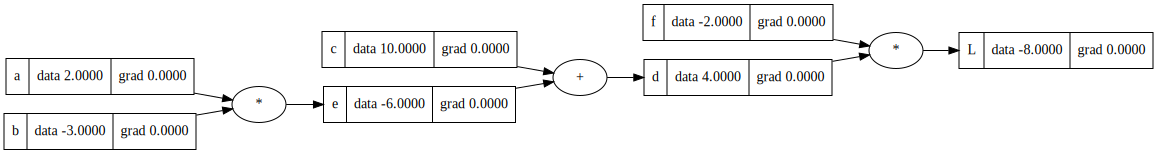

In [11]:
draw_dot(L)

### Manual Backprop
- To check visual updation of computational graph
- To visually understand characteristics of operator nodes during backprop

In [12]:
L.grad = 1.0
d.grad = -2.0
f.grad = 4.0
e.grad = -2.0
c.grad = -2.0
b.grad = -4.0
a.grad = 6.0

In [13]:
"""
gradient check using formula 
"""
def lol():
    
    h = 0.0001
    
    a = Value(2.0, label='a')
    b = Value(-3.0, label='b')
    c = Value(10.0, label='c')
    e = a*b; e.label='e'
    d = e + c; d.label='d'
    f = Value(-2.0, label='f')
    L = d * f; L.label='L'
    L1 = L.data
    
    
    a = Value(2.0, label='a')
    b = Value(-3.0, label='b')
    b.data += h
    c = Value(10.0, label='c')
    e = a*b; e.label='e'
    d = e + c; d.label='d'
    f = Value(-2.0, label='f')
    L = d * f; L.label='L'
    L2 = L.data
    
    print((L2-L1)/h)  # (f(x+h) - f(x))/h

lol()

-4.000000000008441


In [14]:
# tweak weights in the direction of gradient
a.data += 0.01 * a.grad
b.data += 0.01 * b.grad
c.data += 0.01 * c.grad
f.data += 0.01 * f.grad

# forward pass
e = a * b
d = e + c
L = d * f

print(L.data) # Loss goes up // becomes less negative in this case

-7.286496


#### Single Neuron

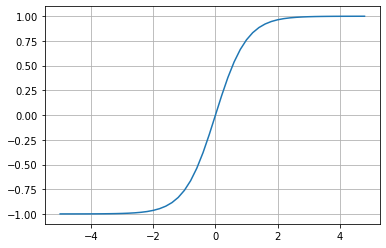

In [15]:
plt.plot(np.arange(-5,5,0.2), np.tanh(np.arange(-5,5,0.2))); plt.grid();

In [16]:
# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195342, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1 * w1; x1w1.label='x1*w1'
x2w2 = x2 * w2; x2w2.label='x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh()

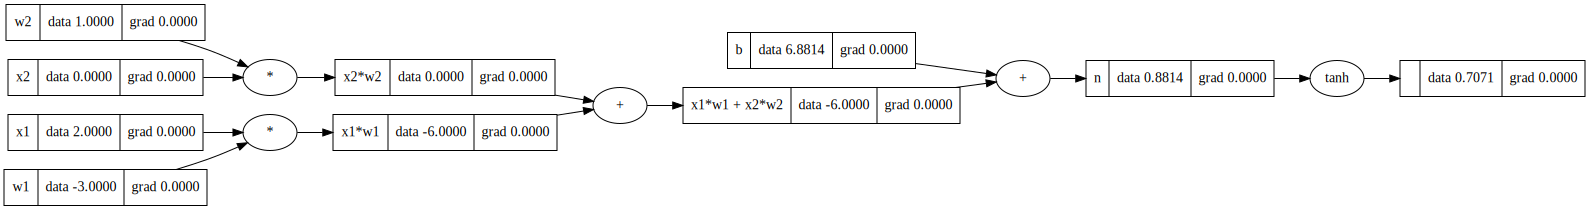

In [17]:
draw_dot(o)

In [18]:
# ^single neuron
o.grad = 1.0

# o = tanh(n)
# do/dn = 1-o**2
n.grad = 0.5  # (1-0.data**2)

x1w1x2w2.grad = 0.5
b.grad = 0.5

x1w1.grad = 0.5
x2w2.grad = 0.5

x2.grad = w2.data * x2w2.grad
w2.grad = x2.data * x2w2.grad

x1.grad = w1.data * x1w1.grad
w1.grad = x1.data * x1w1.grad


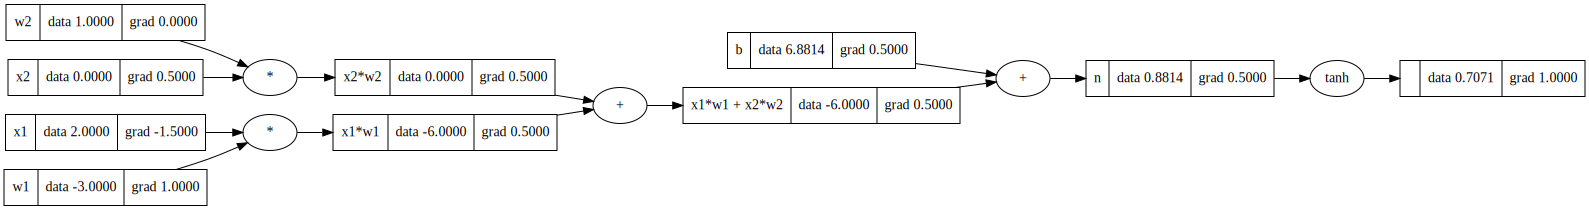

In [19]:
draw_dot(o)

### Auto diff/backprop
Changes/additions made to Value class for autodiff: 
1. defining _backward() for operators in Value class
2. applying topological sort to avoid calling backward multiple times (and to resolve dependencies for backward calls for shallow/earlier nodes)
3. Setting initial(starting) value of global out.grad as 1 (Since backward calculation on operator nodes involves multiplying by the globally maintained derivative)

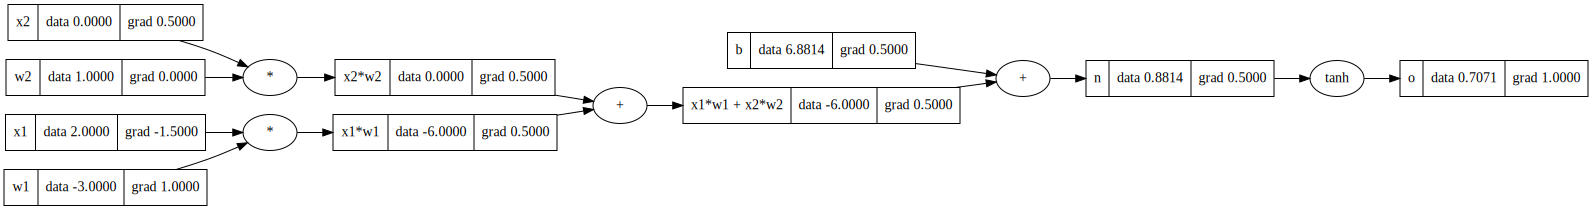

In [31]:
# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195342, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1 * w1; x1w1.label='x1*w1'
x2w2 = x2 * w2; x2w2.label='x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); o.label = 'o'

o.backward()

draw_dot(o)

#### verification of gradient accumulation (because same node can be accessed multiple times)

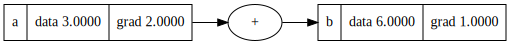

In [32]:
a = Value(3.0, label='a')
b = a + a ; b.label = 'b'
b.backward()
draw_dot(b)

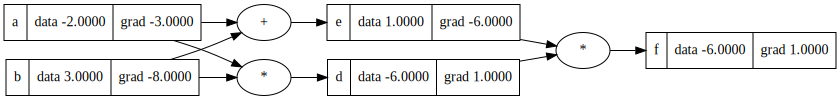

In [33]:
a = Value(-2.0, label='a')
b = Value(3.0, label = 'b')
d = a * b ; d.label = 'd'
e = a + b ; e.label = 'e'
f = d * e ; f.label = 'f'

f.backward()

draw_dot(f)

#### Tanh defined with operations

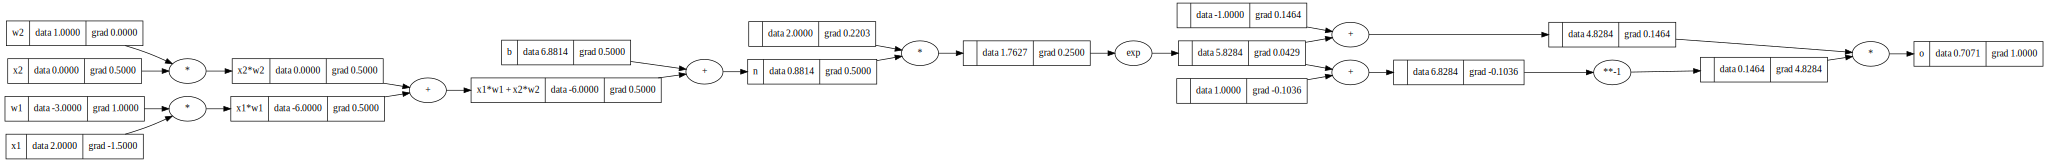

In [43]:
# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195342, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1 * w1; x1w1.label='x1*w1'
x2w2 = x2 * w2; x2w2.label='x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
# -------------------------
e = (2*n).exp()
o = (e-1)/(e+1)
# -------------------------
o.label = 'o'

o.backward()

draw_dot(o)